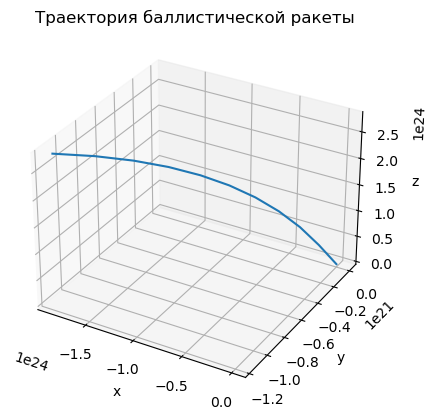

,t,x,y,z,r_0,h
0,0,1,1,1,1,6371095
1,1,-187693602706577764122624,-2541971598634652672,281540388683667233308672,338369441533343396003840,338369441533343396003840
2,2,-375387219031122165891072,-21312736324770189312,563080785002257713201152,676738897289723724693504,676738897289723724693504
3,3,-563080828625856340426752,-67457169195438735360,844621181320848193093632,1015108350892788108230656,1015108350892788108230656
4,4,-750774426500482012807168,-140975268619878268928,1126161577639438672986112,1353477801189403728543744,1353477801189403728543744
5,5,-938468007664701310763008,-241867032133970886656,1407701973958029152878592,1691847247063146316169216,1691847247063146316169216
6,6,-1126161567128216764678144,-370132456400242868224,1689242370276619766988800,2030216687403709111468032,2030216687403709111468032
7,7,-1313855099900731508916224,-525771537207864852480,1970782766595210381099008,2368586121102532601184256,2368586121102532601184256
8,8,-1501548600991950020018176,-708784269472651804672,2252323162913800995209216,2706955547051715207364608,2706955547051715207364608
9,9,-1689242065411577042960384,-919170647237063606272,2533863559232391609319424,3045324964143645262348288,3045324964143645262348288


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# -----------------------------------------------------------------------------------------------
# начальные значения
v0 = 200                                 # начальная скорость БЦ, м/с
theta = 30
phi = 20
# -----------------------------------------------------------------------------------------------
# константы
a = 6378245                             # большая полуось Земли
GM = 3.986004418e14                     # произведение гравитационной постоянной Земли на массу
c_0 = 2.202095e10                       # коэффициент гравитационного поля Земли
omega = 7.292115e-5                     # угловая скорость вращения Земли
f = 298.3                               # коэффициент сжатия Земли
e_squared = (2*f-1)/((f - 1)**2)        # квадрат эксцентриситета Земли
# -----------------------------------------------------------------------------------------------
def equations(coordinate, speed):
    x, y, z = coordinate
    vx, vy, vz = speed
    
    # вычисление производных 
    dx_dt = vx
    dy_dt = vy
    dz_dt = vz
    
    # учет ускорения свободного падения g_0
    r_0 = np.sqrt(x**2 + y**2 + z**2)
    A = GM/r_0**3
    B = (3*c_0)/r_0**2
    C = (15*c_0)/r_0**4
    D = (6*c_0)/r_0**2
    
    dvx_dt = -A*x + A*B*x - A*C*x*z**2
    dvy_dt = -A*y + A*B*y - A*B*y*z**2
    dvz_dt = -A*z + A*B*z - D*z + C*z**3
    
    # учет центростремительного ускорения БЦ
    dvx_dt -= omega**2 * x
    dvy_dt -= omega**2 * y
    dvz_dt -= 0
    
    # учет кориолисова ускорения
    dvx_dt -= 2 * omega * dy_dt
    dvy_dt -= -2 * omega * dx_dt
    dvz_dt -= 0
    
    # учет аэродинамического ускорения 
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    # тк в задании не даны начальная масса БЦ, и другие данные, чтобы посчитать баллистический коэффициент, я приму gamma = 0,347 (нашла значения для пули)
    gamma = 0.347 # для более точных расчетов нужно в процессе полета пересчитывать это значение (но тк начальных параметров нет, здесь я этого не делаю)
    s = z/r_0                                     # синус широты цели
    h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
    rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
    E = (-gamma * rho * v)/2
    
    dvx_dt -= E * dx_dt
    dvy_dt -= E * dy_dt
    dvz_dt -= E * dz_dt
    
    return np.array([dx_dt, dy_dt, dz_dt, dvx_dt, dvy_dt, dvz_dt])
# -------------------------------------------------------------------------------------
def runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed):
    t = t0
    coordinates = [initial_coordinate]
    speeds = [initial_speed]
    
    while t < t_end:
        coordinate = coordinates[-1]
        speed = speeds[-1]
        
        k1 = equations(coordinate, speed)
        q1 = speed
        k2 = equations(coordinate + dt/2 * q1, speed + dt/2 * k1[-3:])
        q2 = q1 + k1[-3:] * dt/2
        k3 = equations(coordinate + dt/2 * q2, speed + dt/2 * k2[-3:])
        q3 = q1 + k2[-3:] * dt/2
        k4 = equations(coordinate + dt * q3, speed + dt * k3[-3:])
        q4 = q1 + k3[-3:] * dt                             
        
        new_coordinate = coordinate + dt/6 * (q1 + 2*q2 + 2*q3 + q4)
        coordinates.append(new_coordinate)
        
        new_speed = speed + dt/6 * (k1[-3:] + 2*k2[-3:] + 2*k3[-3:] + k4[-3:])
        speeds.append(new_speed)
        
        
        t += dt
        
    
    return [np.array(coordinates), np.array(speeds)] # какая то проблема в том что размерности массивов не соотносятся, и я делаю какую то неразрешенныю операцию
# -------------------------------------------------------------------------------------
def main():
    t0 = 0
    t_end = 10
    dt = 1
    
    initial_coordinate = np.array([1, 1, 1])
    initial_speed = np.array([v0 * np.sin(theta) * np.cos(phi), v0 * np.sin(theta) * np.sin(phi), v0 * np.cos(theta)])

    result = runge_kutta_4(t0, t_end, dt, initial_coordinate, initial_speed)
    
    coordinate = result[0]
    speed = result[1]

    # извлечение координат и времени из результата
    x = coordinate[:, 0]
    y = coordinate[:, 1]
    z = coordinate[:, 2]
    vx = speed[:, 0]
    vy = speed[:, 1]
    vz = speed[:, 2]
    t = np.arange(t0, t_end + dt, dt)
    t_list = t.tolist()
    
    
    return [x, y, z, vx, vy, vz, t_list] 
# -------------------------------------------------------------------------------------
result = main()
result_data = pd.DataFrame()
result_data['t'] = list(map(int, result[6]))
result_data['x'] = list(map(int, result[0]))
result_data['y'] = list(map(int, result[1]))
result_data['z'] = list(map(int, result[2]))
# -------------------------------------------------------------------------------------
# Вычисление высоты, скорости и ускорения
x = result[0]
y = result[1]
z = result[2]
vx = result[3]
vy = result[4]
vz = result[5]
t = result[6]

v = np.sqrt(vx**2 + vy**2 + vz**2)
r_0 = np.sqrt(x**2 + y**2 + z**2)
s = z/r_0                                     # синус широты цели
result_data['r_0'] = list(map(int, r_0))
h = r_0 + a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
result_data['h'] = list(map(int, h))

L = np.sqrt(x**2 + y**2)
# -------------------------------------------------------------------------------------
# Визуализация высоты от времени
# plt.figure()
# plt.plot(t, h)
# plt.xlabel('Время t')
# plt.ylabel('Высота h')
# plt.title('Высота от времени h(t)')
# plt.grid(True)

# Визуализация высоты от дальности
# plt.figure()
# plt.plot(L, h)
# plt.xlabel('Дальность L')
# plt.ylabel('Высота h')
# plt.title('Высота от дальности L(h)')
# plt.grid(True)

# Визуализация скорости от времени
# plt.figure()
# plt.plot(t, v)
# plt.xlabel('Время t')
# plt.ylabel('Скорость v')
# plt.title('Скорость от времени v(t)')
# plt.grid(True)

# Визуализация скорости от дальности
# plt.figure()
# plt.plot(L, v)
# plt.xlabel('Дальность L')
# plt.ylabel('Скорость v')
# plt.title('Скорость от дальности v(L)')
# plt.grid(True)

# Визуализация ускорения от времени
# plt.figure()
# plt.plot(t, a)
# plt.xlabel('Время')
# plt.ylabel('Ускорение')
# plt.title('Ускорение от времени')
# plt.grid(True)

# Визуализация ускорения от дальности
# plt.figure()
# plt.plot(x, a)
# plt.xlabel('Дальность')
# plt.ylabel('Ускорение')
# plt.title('Ускорение от дальности')
# plt.grid(True)

# Визуализация траектории ракеты в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектория баллистической ракеты')

plt.show()    
result_data